In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dateutil import parser
from statsmodels.tsa.stattools import grangercausalitytests
from utils import *

In [54]:
# Define the path to the folder containing the CSV files
folder_path = 'pendle_data'

# Initialize an empty DataFrame for the combined data
pt_df = pd.DataFrame()
yt_df = pd.DataFrame()
imp_apy_df = pd.DataFrame()

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        temp_df = pd.read_csv(file_path)
        temp_df['source_file'] = filename[:-4]
        temp_df['maturity'] = get_maturity(temp_df['source_file'].str[-6:])

        if filename.startswith('pt'):
            temp_df = format_data(temp_df, 'pt')
            pt_df = pd.concat([pt_df, temp_df], ignore_index=True)
        elif filename.startswith('yt'):
            temp_df = format_data(temp_df, 'yt')
            yt_df = pd.concat([yt_df, temp_df], ignore_index=True)
        elif filename.startswith('imp_apy'):
            temp_df = format_data(temp_df, 'imp_apy')
            imp_apy_df = pd.concat([imp_apy_df, temp_df], ignore_index=True)
        else:
            print(f'Unknown file type: {filename}')
            continue

# Merge the pt, yt, and imp_apy DataFrames on time, maturity, and token using an outer join
token_price_df = pd.merge(pt_df, yt_df, on=['time', 'maturity', 'token', 'volume'], how='outer')  # volume is always the same for pt and yt
final_df = pd.merge(token_price_df, imp_apy_df, on=['time', 'maturity', 'token'], how='outer')
final_df['time'] = pd.to_datetime(final_df['time'], format='%a %b %d %Y %H:%M:%S GMT%z (Eastern European Summer Time)')
final_df['time'] = final_df['time'].dt.tz_convert('UTC')

In [55]:
final_df[final_df['time'].dt.to_period('M') == '2024-06']

/home/lauri/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:1143: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


,time,volume,pt_price,maturity,token,yt_price,underlyingApy,impliedApy
322,2024-06-01 00:00:00+00:00,3.415657e+02,0.863853,08-2024,ena,0.136147,0.0000,0.8225
323,2024-06-01 01:00:00+00:00,3.721824e+04,0.861686,08-2024,ena,0.138314,0.0000,0.8419
324,2024-06-01 02:00:00+00:00,9.064718e+02,0.861792,08-2024,ena,0.138208,0.0000,0.8415
325,2024-06-01 03:00:00+00:00,3.309835e+04,0.863812,08-2024,ena,0.136188,0.0000,0.8244
326,2024-06-01 04:00:00+00:00,4.903767e+04,0.866812,08-2024,ena,0.133188,0.0000,0.7991
...,...,...,...,...,...,...,...,...
6250,2024-06-30 19:00:00+00:00,1.014127e+06,0.986242,07-2024,susde,0.013758,0.0941,0.2323
6251,2024-06-30 20:00:00+00:00,4.037378e+05,0.986281,07-2024,susde,0.013719,0.0941,0.2320
6252,2024-06-30 21:00:00+00:00,0.000000e+00,0.986320,07-2024,susde,0.013680,0.0941,0.2317
6253,2024-06-30 22:00:00+00:00,5.669438e+04,0.986312,07-2024,susde,0.013688,0.0941,0.2323


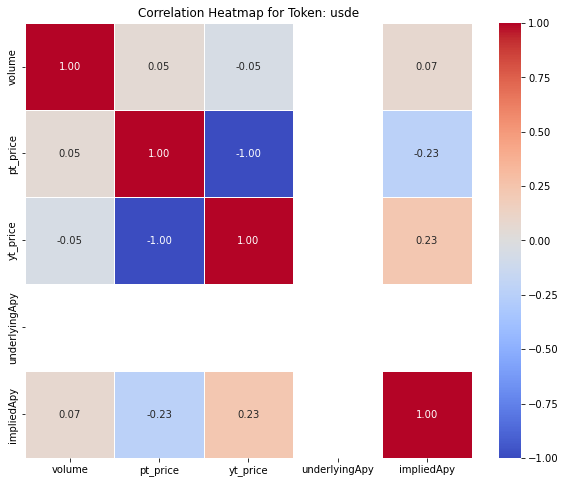

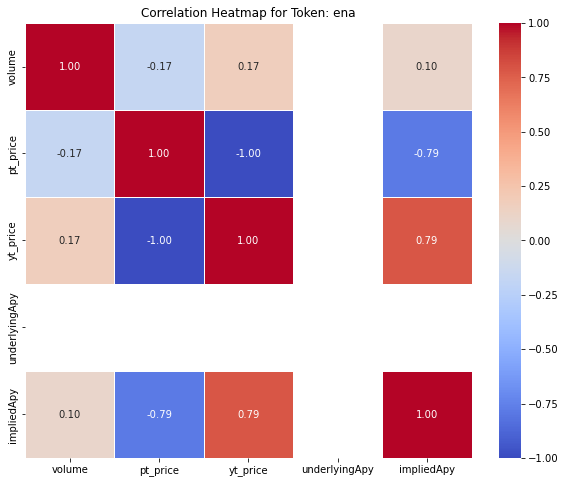

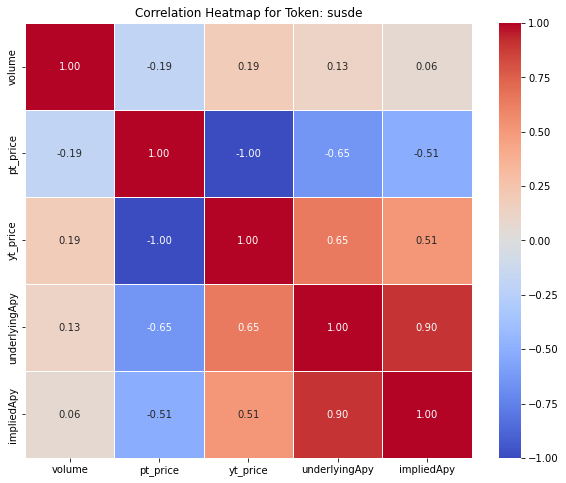

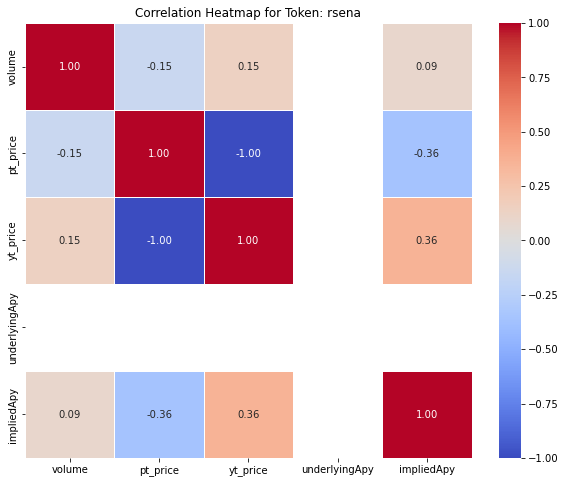

In [56]:
# List of unique tokens
unique_tokens = final_df['token'].unique()

# Loop through each unique token
for token in unique_tokens:
    token_df = final_df[final_df['token'] == token]
    create_correlation_heatmap(token_df, token)


In [57]:
"""
Groupy by token amd maturity, get mean implied apy per day, sum volume
"""

daily_df = final_df.groupby(['token', 'maturity', pd.Grouper(key='time', freq='D')]).agg({
    'volume': 'sum',
    'impliedApy': 'mean',
    'yt_price': 'last',
    'pt_price': 'last',
    'underlyingApy': 'mean'
}).reset_index()
daily_df.to_csv('data/pendle_token_data.csv', index=False)
daily_df

,token,maturity,time,volume,impliedApy,yt_price,pt_price,underlyingApy
0,ena,08-2024,2024-05-25 00:00:00+00:00,9.393385e+05,0.868220,0.143608,0.856392,0.0
1,ena,08-2024,2024-05-26 00:00:00+00:00,8.747086e+05,0.822721,0.146067,0.853933,0.0
2,ena,08-2024,2024-05-27 00:00:00+00:00,2.828536e+06,0.896312,0.150725,0.849275,0.0
3,ena,08-2024,2024-05-28 00:00:00+00:00,1.943333e+06,0.887133,0.143475,0.856525,0.0
4,ena,08-2024,2024-05-29 00:00:00+00:00,2.424128e+06,0.878417,0.146298,0.853702,0.0
...,...,...,...,...,...,...,...,...
295,usde,12-2024,2024-07-20 00:00:00+00:00,1.571316e+05,0.079371,0.036320,0.963680,0.0
296,usde,12-2024,2024-07-21 00:00:00+00:00,6.313509e+04,0.097863,0.039727,0.960273,0.0
297,usde,12-2024,2024-07-22 00:00:00+00:00,3.075975e+04,0.100612,0.039853,0.960147,0.0
298,usde,12-2024,2024-07-23 00:00:00+00:00,1.005253e+05,0.105787,0.041488,0.958512,0.0


<AxesSubplot:>

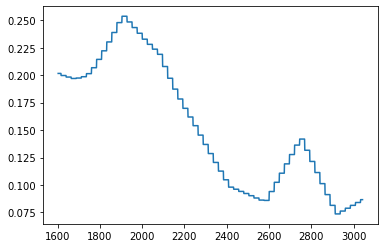

In [58]:
final_df[(final_df['token'] == 'susde') & (final_df['maturity'] == '09-2024')]['underlyingApy'].plot()


### Long Yield Strategy
Previously it was noticed that eth returns granger cause impliedApy on ena. Here we further investigate wether this relationship can be used to predict impliedApy on pendle ena tokens, and thus utilized in a long yield strategy.

Tests will be conducted both on a hourly and daily frequency

In [59]:
from datetime import datetime
from utils import fetch_futures_funding_rates, process_funding_data

# Define parameters
symbol = 'ETHUSDT'  # ETH/USDT perpetual contract
start_date = '2024-04-01'  # Start date (format YYYY-MM-DD)
end_date = datetime.now().strftime('%Y-%m-%d')  # Today's date

# Fetch and process the data
funding_data = fetch_futures_funding_rates(symbol, start_date, end_date)
daily_funding = process_funding_data(funding_data)
daily_funding

,Datetime,Daily Funding Rate,Funding 7-Day MA
0,2024-04-01 00:00:00+00:00,0.116069,NaN
1,2024-04-02 00:00:00+00:00,0.037676,NaN
2,2024-04-03 00:00:00+00:00,0.030000,NaN
3,2024-04-04 00:00:00+00:00,0.030000,NaN
4,2024-04-05 00:00:00+00:00,0.030000,NaN
...,...,...,...
110,2024-07-20 00:00:00+00:00,0.016312,0.019369
111,2024-07-21 00:00:00+00:00,0.018245,0.019184
112,2024-07-22 00:00:00+00:00,0.020436,0.019476
113,2024-07-23 00:00:00+00:00,0.026805,0.020615


In [60]:
final_df[final_df['token'] == 'ena']


,time,volume,pt_price,maturity,token,yt_price,underlyingApy,impliedApy
163,2024-05-25 09:00:00+00:00,124194.408918,0.840575,08-2024,ena,0.159425,0.0,0.9404
164,2024-05-25 10:00:00+00:00,39087.925233,0.843394,08-2024,ena,0.156606,0.0,0.9163
165,2024-05-25 11:00:00+00:00,37034.329809,0.841555,08-2024,ena,0.158445,0.0,0.9329
166,2024-05-25 12:00:00+00:00,48863.604672,0.845139,08-2024,ena,0.154861,0.0,0.9023
167,2024-05-25 13:00:00+00:00,5298.960595,0.844842,08-2024,ena,0.155158,0.0,0.9054
...,...,...,...,...,...,...,...,...
1598,2024-07-24 04:00:00+00:00,0.000000,0.953437,08-2024,ena,0.046563,0.0,0.6253
1599,2024-07-24 05:00:00+00:00,5274.411551,0.953162,08-2024,ena,0.046838,0.0,0.6310
1600,2024-07-24 06:00:00+00:00,6164.731871,0.953514,08-2024,ena,0.046486,0.0,0.6258
1601,2024-07-24 07:00:00+00:00,15282.582619,0.952608,08-2024,ena,0.047392,0.0,0.6426


In [61]:
external_data = pd.read_csv('data/ena_1h_data.csv')
external_data['time'] = pd.to_datetime(external_data['Datetime'])

combined_df = pd.merge(final_df, external_data.drop(columns='Datetime'), on='time').sort_values('time')
combined_df['impliedApy'] = combined_df['impliedApy'].diff()
combined_df['underlyingApy'] = combined_df['underlyingApy'].diff()

causality_hypothesis_variables = ['ETH_Returns', 'ENA_Returns', 'underlyingApy']
y_values = ['impliedApy', 'underlyingApy']
tokens = combined_df['token'].unique()
maturities = combined_df['maturity'].unique()

hourly_results = run_granger_causality_tests(combined_df, tokens, y_values, causality_hypothesis_variables, maturities)

Skipping ETH_Returns -> impliedApy due to constant values in data for token ena at maturity 09-2024.
Skipping ENA_Returns -> impliedApy due to constant values in data for token ena at maturity 09-2024.
Skipping underlyingApy -> impliedApy due to constant values in data for token ena at maturity 09-2024.
Skipping ETH_Returns -> underlyingApy due to constant values in data for token ena at maturity 09-2024.
Skipping ENA_Returns -> underlyingApy due to constant values in data for token ena at maturity 09-2024.
Skipping ETH_Returns -> impliedApy due to constant values in data for token ena at maturity 07-2024.
Skipping ENA_Returns -> impliedApy due to constant values in data for token ena at maturity 07-2024.
Skipping underlyingApy -> impliedApy due to constant values in data for token ena at maturity 07-2024.
Skipping ETH_Returns -> underlyingApy due to constant values in data for token ena at maturity 07-2024.
Skipping ENA_Returns -> underlyingApy due to constant values in data for token

In [62]:
hourly_results

{'ena': {'08-2024': {'impliedApy': {'ETH_Returns': [0.3304931003400968,
     0.370248113447603,
     0.3951665471624304,
     0.5512169941265351,
     0.21799526081946657,
     0.03848754268727234,
     0.036696024277567164,
     0.025405200909154973,
     0.03129670452650625,
     0.04772507898980754],
    'ENA_Returns': [0.43386125744752446,
     0.805956205018015,
     0.34540161183649654,
     0.47078778923153475,
     0.47483727816790466,
     0.22392650377038137,
     0.30671664025590706,
     0.3968722139667241,
     0.43437527082181937,
     0.5833017956841919],
    'underlyingApy': [2.350898469336861e-06,
     9.98180896431047e-10,
     2.8592750652610047e-08,
     4.727770838881104e-07,
     1.1555035823552246e-05,
     3.9676591224265994e-05,
     0.0001673716122214991,
     0.0006350884626187916,
     0.0012938210046348094,
     0.00293169826657819]},
   'underlyingApy': {'ETH_Returns': [0.5076221619844021,
     0.5002600656432536,
     0.6760676645659376,
     0.6562337611

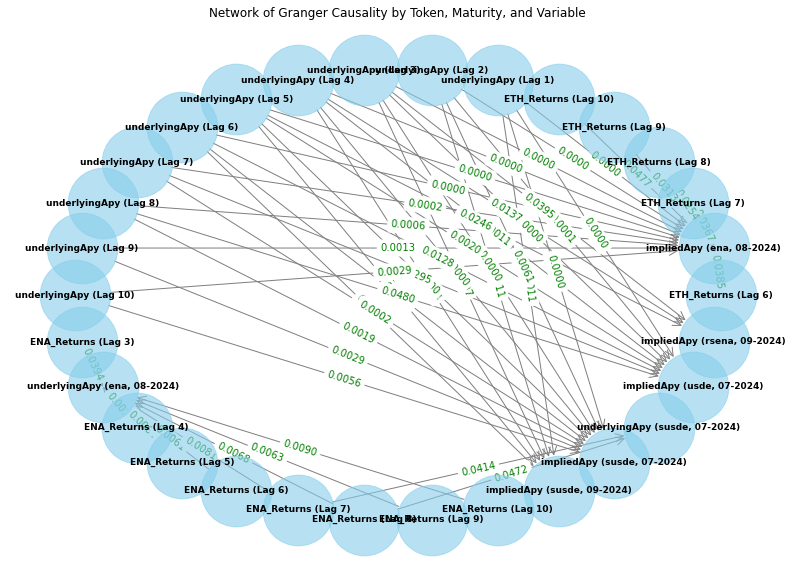

In [70]:
import networkx as nx
import matplotlib.pyplot as plt

plot_granger_causality_network(hourly_results, 0.05, 'circular')

# Daily level granger causality
- Needs some fixing; there should not be any underlyingAoy available on a daily level for other tokens than susde

In [64]:
daily_external_data = pd.read_csv('data/ena_1d_data.csv')
daily_external_data['time'] = pd.to_datetime(daily_external_data['Datetime'])

daily_combined_df = pd.merge(daily_df, daily_external_data.drop(columns='Datetime'), on='time').sort_values('time')

# stationarize impliedApy and underlyingApy
daily_combined_df['impliedApy'] = daily_combined_df['impliedApy'].diff()
daily_combined_df['underlyingApy'] = daily_combined_df['underlyingApy'].diff()

# Define the variables for analysis
causality_hypothesis_variables = ['ETH_Returns', 'ENA_Returns', 'underlyingApy']
y_values = ['impliedApy', 'underlyingApy']
tokens = daily_combined_df['token'].unique()
maturities = daily_combined_df['maturity'].unique()

causality_results = run_granger_causality_tests(daily_combined_df, tokens, y_values, causality_hypothesis_variables, maturities)

Skipping ETH_Returns -> impliedApy due to constant values in data for token ena at maturity 07-2024.
Skipping ENA_Returns -> impliedApy due to constant values in data for token ena at maturity 07-2024.
Skipping underlyingApy -> impliedApy due to constant values in data for token ena at maturity 07-2024.
Skipping ETH_Returns -> underlyingApy due to constant values in data for token ena at maturity 07-2024.
Skipping ENA_Returns -> underlyingApy due to constant values in data for token ena at maturity 07-2024.
Skipping ETH_Returns -> impliedApy due to constant values in data for token ena at maturity 09-2024.
Skipping ENA_Returns -> impliedApy due to constant values in data for token ena at maturity 09-2024.
Skipping underlyingApy -> impliedApy due to constant values in data for token ena at maturity 09-2024.
Skipping ETH_Returns -> underlyingApy due to constant values in data for token ena at maturity 09-2024.
Skipping ENA_Returns -> underlyingApy due to constant values in data for token

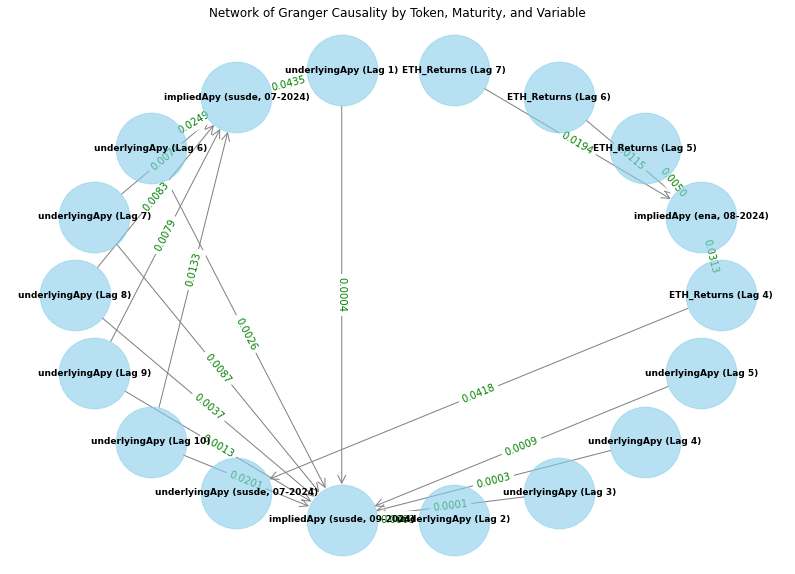

In [71]:
plot_granger_causality_network(causality_results, 0.05, 'circular')

### Observations

Observations:

1) Hourly data:
- ENA returns granger cause impliedApy on some tokens
- ETH returns has weaker granger causality on impliedApy, but displays significant granger causality on underlyingApy
- underlyingApy, as one could expect, has a strong granger causality on impliedApy on susde

The relationship of ETH and ENA returns granger causing underlyingApy, and underlyingApy granger causing impliedApy on susde, could perhaps be used to predict impliedApy on susde. This could be used in a long yield strategy, where one would long susde when the model predicts a high impliedApy, and short when the model predicts a low impliedApy.

2) Daily data:
- ETH returns granger cause impliedApy on susde on several lags on hourly frequency - this is not the case on the daily frequency.
- The implied APY of ENA is granger caused by several lags of ETH returns even on the daily frequency.



### VAR Model
- See if past lags of impliedApy and lags of other variables can predict impliedApy of tokens on ENA.

In [72]:
from statsmodels.tsa.api import VAR
# Check out what are the best lags for predicting impliedApy


# Define the variables for the VAR model
var_variables = ['impliedApy', 'ETH_Returns', 'ENA_Returns', 'underlyingApy']

# Check out what are the best lags for predicting impliedApy
# Select data for specific token
data = combined_df[(combined_df['token'] == 'susde') & (combined_df['maturity'] == '09-2024')][var_variables]
data['impliedApy'] = data['impliedApy'].diff()
data['underlyingApy'] = data['underlyingApy'].diff()
data.dropna(inplace=True)

import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from sklearn.model_selection import train_test_split


# Function to perform ADF test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Values {key}: {value}')

# Check stationarity and difference data if necessary
for var in var_variables:
    print(f"Results for {var}:")
    adf_test(data[var])
    print("\n")

# Differencing if not stationary
data_differenced = data.diff().dropna()

# Splitting the dataset into train and test sets
n_obs = 4  # Number of observations to test, adjust as needed
train, test = data_differenced[:-n_obs], data_differenced[-n_obs:]

# Creating and fitting the VAR model
model = VAR(train)
selected_model = model.fit(maxlags=2, ic='aic')
print(f'Best lag order = {selected_model.k_ar}')

# Forecasting
forecast = selected_model.forecast(train.values[-selected_model.k_ar:], steps=n_obs)
forecast_df = pd.DataFrame(forecast, index=data.index[-n_obs:], columns=data.columns)

# Display forecast
print("Forecast:")
print(forecast_df)

# Optionally, evaluate the model (MAE, RMSE, etc.)
from sklearn.metrics import mean_squared_error

for var in var_variables:
    mse = mean_squared_error(test[var], forecast_df[var])
    print(f'MSE for {var}: {mse}')


Results for impliedApy:
ADF Statistic: -14.271062713395294
p-value: 1.3740536463135956e-26
Critical Values 1%: -3.435153261837347
Critical Values 5%: -2.8636612797849814
Critical Values 10%: -2.567899369049974


Results for ETH_Returns:
ADF Statistic: -38.03257297795227
p-value: 0.0
Critical Values 1%: -3.435097467737946
Critical Values 5%: -2.8636366587977804
Critical Values 10%: -2.5678862576139467


Results for ENA_Returns:
ADF Statistic: -12.104076882345748
p-value: 1.9875095807077017e-22
Critical Values 1%: -3.435128691376705
Critical Values 5%: -2.8636504373148703
Critical Values 10%: -2.567893595090765


Results for underlyingApy:
ADF Statistic: -14.611097865230175
p-value: 4.0216542110025876e-27
Critical Values 1%: -3.4351603284454986
Critical Values 5%: -2.863664398126376
Critical Values 10%: -2.567901029668299


Best lag order = 2
Forecast:
     impliedApy  ETH_Returns  ENA_Returns  underlyingApy
920   -0.084875    -0.010996    -0.017710       0.008220
929    0.451596     0.0

/home/lauri/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


### PACF - impliedApy

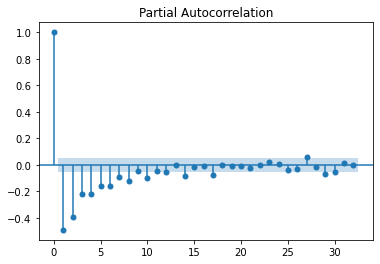

In [67]:
# import plot_pacf etc
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(data['impliedApy'].dropna())
plt.show()

In [74]:
# import pearsonr
from scipy.stats import pearsonr

def optimal_lag(impliedApy: pd.Series, lagged_variable: pd.Series, max_lag: int) -> None:
    """
    Function to find the optimal lag for a VAR model
    :param impliedApy: Series with the target variable
    :param lagged_variable: Series with the variable from which lags are created
    :param max_lag: Maximum number of lags to test
    :return: Prints the optimal lag and best p-value
    """
    
    best_lag = None
    best_p_value = float('inf')  # Initialize with infinity for minimization

    for lag in range(1, max_lag + 1):  # Ensure the loop runs up to max_lag
        if len(lagged_variable) > lag:  # Check to ensure there's enough data for the lag
            lag_series = lagged_variable.shift(lag)  # Shift the series to create lag
            lag_series.dropna(inplace=True)  # Drop NaN values that appear due to shifting
            impliedApy_aligned = impliedApy.loc[lag_series.index]  # Align impliedApy to the same index
            
            correlation, p_value = pearsonr(impliedApy_aligned, lag_series)
            
            if p_value < best_p_value:
                best_lag = lag
                best_p_value = p_value

            print(f'Lag: {lag}')
            print(f'Correlation: {correlation}, p-value: {p_value}')
            print('----------------')
    
    print(f'Best lag: {best_lag}, Best p-value: {best_p_value}')

# Example usage:
# Ensure test['impliedApy'] and test['ENA_Returns'] are pandas Series.
optimal_lag(data['impliedApy'], data['underlyingApy'], 10)


Lag: 1
Correlation: 0.21325167665447065, p-value: 1.174970107856512e-15
----------------
Lag: 2
Correlation: 0.016539211838632852, p-value: 0.5394355232561143
----------------
Lag: 3
Correlation: -0.0013174624566685764, p-value: 0.9610294956331276
----------------
Lag: 4
Correlation: 0.0170315039890054, p-value: 0.5277293011258345
----------------
Lag: 5
Correlation: -0.01172665795282131, p-value: 0.6638427589975487
----------------
Lag: 6
Correlation: -0.0017664490440410761, p-value: 0.947821954957924
----------------
Lag: 7
Correlation: -0.015832389652594064, p-value: 0.5576270200847259
----------------
Lag: 8
Correlation: 0.05161117454623404, p-value: 0.05588470021116768
----------------
Lag: 9
Correlation: -0.0680849936308773, p-value: 0.011651324210754191
----------------
Lag: 10
Correlation: 0.0409798411467716, p-value: 0.12936408312028935
----------------
Best lag: 1, Best p-value: 1.174970107856512e-15


##### Observations
- ETH best lag is 10
- ENA best lag is 1

In [69]:
# Define the variables for the VAR model

# Train test split
train, test = train_test_split(data, test_size=0.2)

model = VAR(train)

model_fit = model.fit(maxlags=10)

model_fit.summary()

/home/lauri/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 25, Jul, 2024
Time:                     18:40:19
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -27.0319
Nobs:                     1094.00    HQIC:                  -27.4975
Log likelihood:           9150.95    FPE:                8.60819e-13
AIC:                     -27.7810    Det(Omega_mle):     7.43015e-13
--------------------------------------------------------------------
Results for equation impliedApy
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.004676         0.008780            0.533           0.594
L1.impliedApy            -0.033398         0.035178           -0.949           0.342
L1.ETH_Returns           -2.862659     